In [ ]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 503 kB 44.3 MB/s 
     |████████████████████████████████| 3.8 MB 35.9 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e093481f7cec7643f56ee81381b633b9d4b70e8bf85179286e5e37240665e4be
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
import tensorflow as tf
import os, subprocess, re
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import shutil
import json
from google.protobuf import text_format
import pprint
import random
from pathlib import Path
from google.protobuf import text_format

%matplotlib inline
!tar -xf {checkpoint_name}.tar.gz

tar: {checkpoint_name}.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
# !tar -xf ssd.tar.gz


In [ ]:
# !tar -xf taco.tar.gz


^C


In [ ]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone --depth 1 https://github.com/tensorflow/models.git -b v1.13.0 \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2428/2428), done.
remote: Total 2927 (delta 504), reused 2113 (delta 424), pack-reused 0
Receiving objects: 100% (2927/2927), 369.04 MiB | 27.41 MiB/s, done.
Resolving deltas: 100% (504/504), done.
Note: checking out '57e075203f8fba8d85e6b74f17f63d0a07da233a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Checking out files: 100% (2768/2768), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
# install object_detection library
! pip3 install pycocotools > /dev/null
! cd ./models/research && \
    protoc object_detection/protos/*.proto --python_out=. && \
    python3 setup.py build > /dev/null && \
    python3 setup.py bdist_wheel > /dev/null
! python3 -m pip install --no-cache-dir ./models/research/dist/object_detection-0.1-py3-none-any.whl > /dev/null
! cd ./models/research/slim && \
    python3 setup.py bdist_wheel > /dev/null
! python3 -m pip install --no-cache-dir ./models/research/slim/dist/slim-0.1-py3-none-any.whl > /dev/null

In [ ]:
from object_detection.utils import dataset_util, label_map_util
from object_detection.dataset_tools.create_coco_tf_record import create_tf_example
from object_detection.protos import string_int_label_map_pb2
from object_detection.protos import pipeline_pb2
from object_detection.utils import visualization_utils as vis_util

In [ ]:
MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'
DATA_DIR = './nn-models'
MODEL_DIR = os.path.join(DATA_DIR, MODEL)
URL = 'http://download.tensorflow.org/models/object_detection/%s.tar.gz' % MODEL
DOWNLOAD_PATH = '%s/%s.tar.gz' % (DATA_DIR, MODEL)

In [ ]:
if not os.path.exists(DATA_DIR):
    subprocess.run(['mkdir', DATA_DIR])

In [ ]:
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2

def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [ ]:
def download():
    print("Downloading %s.." % MODEL)
    p = subprocess.run(['wget', '--show-progress', '--progress=bar:force', '-O', DOWNLOAD_PATH, URL])

    print("Unpacking..")
    p = subprocess.run(['tar', 'zxvf', DOWNLOAD_PATH, '-C', DATA_DIR])
    p = subprocess.run(['rm', DOWNLOAD_PATH])

    print("Checking..")
    pbfile = os.path.join(MODEL_DIR, 'frozen_inference_graph.pb')
    reconstruct(pbfile)

In [ ]:
if os.path.exists(MODEL_DIR):
    subprocess.run(['rm', '-r', MODEL_DIR])
    subprocess.run(['mkdir', MODEL_DIR])
download()

Unpacking..
Checking..
Reconstructing Tensorflow model
Success!


In [ ]:
PB_PATH = "./nn-models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
LABEL_PATH = './models/research/object_detection/data/mscoco_label_map.pbtxt'

NCLASSES = 60

In [ ]:
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [ ]:
detection_graph = reconstruct(PB_PATH)

Reconstructing Tensorflow model
Success!


In [ ]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

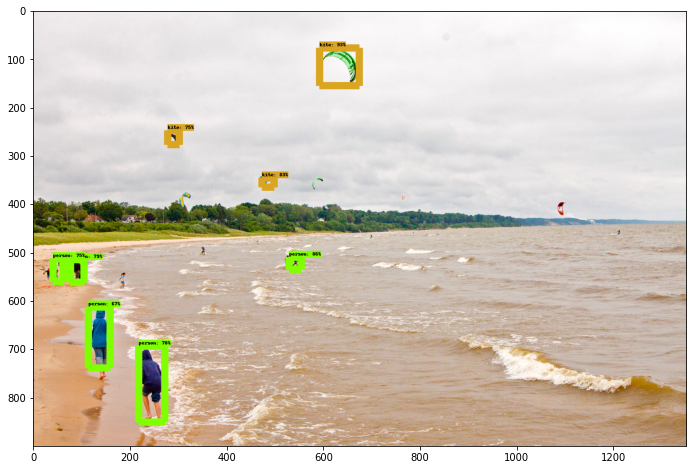

In [ ]:
detect(detection_graph, './models/research/object_detection/test_images/image2.jpg')

In [ ]:
TACO_DIR = './data/garbagedetection/TACO'
DATA_DIR = '/content/tacotrashdataset/data'
IMAGES_SUB_DIR = 'images'
IMAGES_DIR = os.path.join(TACO_DIR, IMAGES_SUB_DIR)
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')

TRAIN_PROP = .80
SEED = 123

In [ ]:
if not os.path.exists(IMAGES_DIR):
    subprocess.run(['mkdir', '-p', IMAGES_DIR])

In [ ]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

images = data['images']
categories = data['categories']
annotations = data['annotations']

images_annotations = []
for idx, image in enumerate(images):
    image_id = int(image['id'])
    random_number = idx
    file_name = image['file_name']

    # rename files to unique numbers
    new_file_name = '%s.jpg' % str(random_number)
    file_location = '%s/%s' % (DATA_DIR, file_name)
    new_file_location = '%s/%s' % (IMAGES_DIR, new_file_name)
    if os.path.isfile(file_location):
        # print('renamed: %s to %s' % (file_location, new_file_location))
        shutil.copy(file_location, new_file_location)
    image['file_name'] = new_file_name
    image['folder'] = DATA_DIR

    # get annotations for the image
    _annotations = [a for a in annotations if int(a['image_id']) == image_id]

    # something wrong with y coordinates in data
    for a in _annotations:
        (x,y,w,h) = a['bbox']
        a['bbox'][1] = image['height'] - y - h

    images_annotations.append((image, _annotations))

In [ ]:
np.random.seed(SEED)

images_annotations_idx = range(0,len(images_annotations))

images_annotations_train_idx = np.random.choice(
    len(images_annotations),
    size=int(len(images_annotations)*TRAIN_PROP),
    replace=False
)
images_annotations_train = [images_annotations[i] for i in images_annotations_train_idx]

images_annotations_val_idx = np.random.choice(
    list(set(images_annotations_idx)-set(images_annotations_train_idx)),
    size=int(len(images_annotations_idx)*(1-TRAIN_PROP)/2),
    replace=False
)
images_annotations_val = [images_annotations[i] for i in images_annotations_val_idx]

images_annotations_test_idx = list(set(images_annotations_idx)-set(images_annotations_train_idx)-set(images_annotations_val_idx))
images_annotations_test = [images_annotations[i] for i in images_annotations_test_idx]

print(
'''
# TRAIN IMAGES: %d
# VALIDATION IMAGES: %d
# TEST IMAGES: %d
''' % (len(images_annotations_train), len(images_annotations_val), len(images_annotations_test))
)


# TRAIN IMAGES: 1200
# VALIDATION IMAGES: 149
# TEST IMAGES: 151



In [ ]:
LABEL_PATH = os.path.join(TACO_DIR, 'labelmap.pbtxt')

if not os.path.exists(LABEL_PATH):
    print('Building label map from examples')

    from object_detection.protos import string_int_label_map_pb2
    from google.protobuf import text_format

    labelmap = string_int_label_map_pb2.StringIntLabelMap()
    for category in categories:
        item = labelmap.item.add()
        # label map id 0 is reserved for the background label
        item.id = int(category['id'])+1
        item.name = category['name']

    with open(LABEL_PATH, 'w') as f:
        f.write(text_format.MessageToString(labelmap))

    print('Label map witten to labelmap.pbtxt')
else:
    print('Reusing existing labelmap.pbtxt')

with open(LABEL_PATH, 'r') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [ ]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
def build_tfrecords(dataset, output_path, images_annotations, category_index):
    writer = tf.compat.v1.python_io.TFRecordWriter(output_path)
    label_map_dict = label_map_util.get_label_map_dict(LABEL_PATH)

    print("Building TFRecord files for dataset: %s" % dataset)

    for idx, (image, _annotations) in enumerate(images_annotations):
        if idx % 100 == 0:
            print('%d of %d annotations' % (idx, len(images_annotations)))

        _, tf_example, num_annotations_skipped = create_tf_example(
            image=image,
            annotations_list=_annotations,
            image_dir=IMAGES_DIR,
            category_index=category_index,
            include_masks=False
        )

        writer.write(tf_example.SerializeToString())

    writer.close()
    print("Done!")

In [ ]:
# need a category_index here 0 based for making tf-records
_category_index = label_map_util.create_category_index(data['categories'])

datasets = [('train', images_annotations_train), ('test', images_annotations_test), ('val', images_annotations_val)]
for dataset,images_annotations in datasets:
    output_path = os.path.join(TACO_DIR, '%s.record' % dataset)
    build_tfrecords(dataset, output_path, images_annotations, _category_index)

Building TFRecord files for dataset: train
0 of 1200 annotations
100 of 1200 annotations
200 of 1200 annotations
300 of 1200 annotations
400 of 1200 annotations
500 of 1200 annotations
600 of 1200 annotations
700 of 1200 annotations
800 of 1200 annotations
900 of 1200 annotations
1000 of 1200 annotations
1100 of 1200 annotations
Done!
Building TFRecord files for dataset: test
0 of 151 annotations
100 of 151 annotations
Done!
Building TFRecord files for dataset: val
0 of 149 annotations
100 of 149 annotations
Done!


In [ ]:
BATCH_SIZE = 10 # 24
BATCH_NMS_SCORE_THRESHOLD = .1
TENSORBOARD_NUM_IMAGES = 20

In [ ]:
SRC_CONFIG_TEMPLATE_PATH = './nn-models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config'
SRC_CHECKPOINT_PATH =  './nn-models/ssd_mobilenet_v2_coco_2018_03_29/model.ckpt'

# SRC_CONFIG_TEMPLATE_PATH = './nn-models/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config'
# SRC_CHECKPOINT_PATH =  './nn-models/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt'



MODEL_DIR = './nn-models/garbagedetection/ssd_mobilenet_v2/'
DATA_DIR = './data/garbagedetection/TACO/data/'

CHECKPOINT_PATH_HOST = os.path.join(MODEL_DIR, 'model.ckpt')
LABEL_MAP_PATH_HOST = os.path.join(TACO_DIR, 'labelmap.pbtxt')
TRAIN_RECORDS_PATH_HOST = os.path.join(TACO_DIR, 'train.record')
VAL_RECORDS_PATH_HOST = os.path.join(TACO_DIR, 'val.record')

In [ ]:
label_map_dict = label_map_util.get_label_map_dict(os.path.join(TACO_DIR, 'labelmap.pbtxt'))
NUM_CLASSES = len(label_map_dict.keys())

In [ ]:
print('''
Config parameters:

CHECKPOINT_PATH_HOST = %s
LABEL_MAP_PATH_HOST = %s
TRAIN_RECORDS_PATH_HOST = %s
VAL_RECORDS_PATH_HOST = %s
BATCH_SIZE = %d
NUM_CLASSES = %d
BATCH_NMS_SCORE_THRESHOLD = %f
TENSORBOARD_NUM_IMAGES = %d
''' % (
    CHECKPOINT_PATH_HOST, 
    LABEL_MAP_PATH_HOST,
    TRAIN_RECORDS_PATH_HOST,
    VAL_RECORDS_PATH_HOST,
    BATCH_SIZE,
    NUM_CLASSES,
    BATCH_NMS_SCORE_THRESHOLD,
    TENSORBOARD_NUM_IMAGES
))


Config parameters:

CHECKPOINT_PATH_HOST = ./nn-models/garbagedetection/ssd_mobilenet_v2/model.ckpt
LABEL_MAP_PATH_HOST = ./data/garbagedetection/TACO/labelmap.pbtxt
TRAIN_RECORDS_PATH_HOST = ./data/garbagedetection/TACO/train.record
VAL_RECORDS_PATH_HOST = ./data/garbagedetection/TACO/val.record
BATCH_SIZE = 12
NUM_CLASSES = 60
BATCH_NMS_SCORE_THRESHOLD = 0.100000
TENSORBOARD_NUM_IMAGES = 20



In [ ]:
%%bash
echo "
diff --git a/models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config b/pipeline.config
index 1853c65..0b459dd 100755
--- a/models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
+++ b/pipeline.config
@@ -32,7 +32,6 @@ model {
           train: true
         }
       }
-      batch_norm_trainable: true
       use_depthwise: true
     }
     box_coder {
" > ssd_mobilenet_v2_coco_2018_03_29_pipeline.config.patch

In [ ]:
! patch -N './nn-models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config' < ./ssd_mobilenet_v2_coco_2018_03_29_pipeline.config.patch

patching file ./nn-models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config


In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.compat.v2.io.gfile.GFile(SRC_CONFIG_TEMPLATE_PATH, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [ ]:
pipeline_config.model.ssd.num_classes = NUM_CLASSES
pipeline_config.train_config.batch_size = BATCH_SIZE
pipeline_config.train_config.fine_tune_checkpoint = CHECKPOINT_PATH_HOST
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = TRAIN_RECORDS_PATH_HOST
pipeline_config.train_input_reader.label_map_path = LABEL_MAP_PATH_HOST
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = VAL_RECORDS_PATH_HOST
pipeline_config.eval_input_reader[0].label_map_path = LABEL_MAP_PATH_HOST
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.score_threshold = BATCH_NMS_SCORE_THRESHOLD
pipeline_config.eval_config.num_visualizations = TENSORBOARD_NUM_IMAGES

In [ ]:
if not os.path.exists(MODEL_DIR):
    subprocess.run(['mkdir', '-p', MODEL_DIR])

config_text = text_format.MessageToString(pipeline_config)
with tf.compat.v2.io.gfile.GFile(os.path.join(MODEL_DIR, 'pipeline.config'), "wb") as f:
    f.write(config_text)

In [ ]:
! cp -r $SRC_CHECKPOINT_PATH\.* $MODEL_DIR

In [ ]:
MODEL_ROOT_DIR = './nn-models/garbagedetection/ssd_mobilenet_v2'
CONFIG_PATH = os.path.join(MODEL_ROOT_DIR, 'pipeline.config')
TRAINING_STEPS = 10
EVAL_STEPS = 10

In [ ]:
! python3 ./models/research/object_detection/model_main.py \
    --pipeline_config_path=$CONFIG_PATH \
    --model_dir=$MODEL_ROOT_DIR \
    --alsologtostderr \
    --num_train_steps=$TRAINING_STEPS \
    --num_eval_steps=$EVAL_STEPS

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1111 21:03:15.901618 140580490864512 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/object_detection/utils/config_util.py:94: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1111 21:03:15.905457 140580490864512 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib.py:573: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1111 21:03:15.905660 140580490864512 model_lib.py:574] Forced number of epochs for all eval validations to be 1.

W1111 21:03:15.905810 140580490864512 module_wrapper.py:13

In [ ]:
! python3 ./models/research/object_detection/export_inference_graph.py --input_type=image_tensor --pipeline_config_path=$MODEL_ROOT_DIR/pipeline.config --trained_checkpoint_prefix=$MODEL_ROOT_DIR/model.ckpt-$TRAINING_STEPS --output_directory=$MODEL_ROOT_DIR

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1111 21:19:32.581467 140530105984896 module_wrapper.py:139] From ./models/research/object_detection/export_inference_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1111 21:19:32.595693 140530105984896 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/object_detection/exporter.py:348: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1111 21:19:32.596336 140530105984896 module_wrapper.py:139] From /usr/local/lib/python3.7/dist-packages/object_detection/exporter.py:113: The name tf.placeholder is deprecated. Please use tf.compa

In [ ]:
trained_detection_graph = reconstruct('./nn-models/garbagedetection/ssd_mobilenet_v2/frozen_inference_graph.pb')

Reconstructing Tensorflow model
Success!


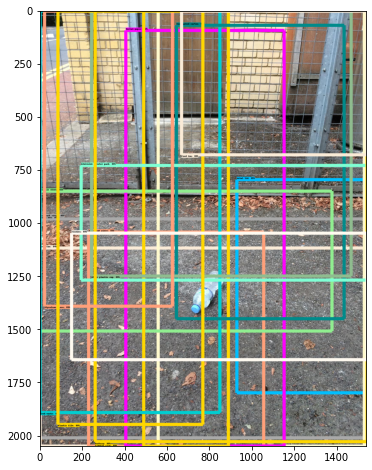

In [ ]:
detect(trained_detection_graph, '/content/tacotrashdataset/data/batch_1/000000.jpg')

In [ ]:
trained_detection_graph = reconstruct('/content/trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb')

Reconstructing Tensorflow model
Success!


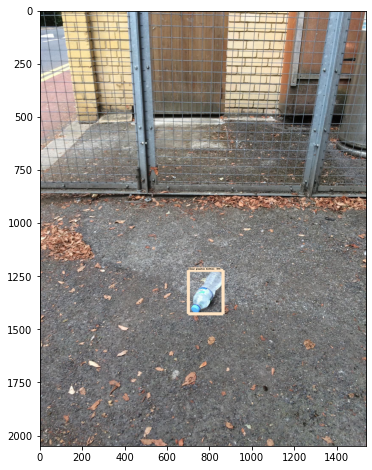

In [ ]:
detect(trained_detection_graph, '/content/tacotrashdataset/data/batch_1/000000.jpg')

In [ ]:
detect(trained_detection_graph, '/content/tacotrashdataset/data/batch_6/000000.jpg')

In [ ]:
# NOTE: Pieces taken from https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
# The github.com/tensorflow/models is distributed under the Apache 2.0 license.

import numpy
import tensorflow as tf

tf.reset_default_graph()
!rm -f /content/logs/*

with tf.get_default_graph().as_default() as graph:  
  summary_writer = tf.summary.FileWriter("/content/logs/", flush_secs=1)

  # This section builds a "graph" in TensorFlow to explain how to process the data.
  jpeg_input_tensor = tf.placeholder(tf.string, ())  # We will provide a JPEG to TF.

  # First, instruct TF to decode the JPEG string into a matrix.
  image = tf.image.decode_image(jpeg_input_tensor)
  image_tensor = tf.expand_dims(image, 0)

  # Load the Mobilenetv2 + SSDLite graph from disk.
  ssdlite_graph = tf.GraphDef()
  # with open('{}/frozen_inference_graph.pb'.format(checkpoint_name), 'rb') as f:
  # with open('/content/nn-models/garbagedetection/ssd_mobilenet_v2/frozen_inference_graph.pb', 'rb') as f:
  with open('/content/trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb', 'rb') as f:
    ssdlite_graph.ParseFromString(f.read())
    
  # Tell TensorFlow we would like to inspect these parts of the network.
  output_names = ['num_detections:0', 
                  'detection_boxes:0', 
                  'detection_scores:0',
                  'detection_classes:0']
  ops = dict(zip(output_names, tf.graph_util.import_graph_def(
      ssdlite_graph, 
      input_map={'image_tensor': image_tensor},
      return_elements=output_names)))
    
  # Also extract the decoded image from the network to draw bounding boxes.
  ops['image'] = image
  
  summary_writer.add_graph(graph)
  summary_writer.flush()


def run_detection(sess, img):
  """Run one detection round."""
  output_dict = sess.run(ops, feed_dict={jpeg_input_tensor: img})

  # all outputs are float32 numpy arrays, so convert types as appropriate
  output_dict['num_detections'] = int(output_dict['num_detections:0'][0])
  output_dict['detection_classes'] = output_dict[
      'detection_classes:0'][0].astype(numpy.int64)
  output_dict['detection_boxes'] = output_dict['detection_boxes:0'][0]
  output_dict['detection_scores'] = output_dict['detection_scores:0'][0]
  
  return output_dict

print('Model configured')

Model configured


In [ ]:
import base64
import html
import io
import time

# setup path so that mobilenet_v2 can be found.
import sys
sys.path.append('/content/models/research')
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils

# Taken from https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=SucxddsPhOmj
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy
import PIL.Image

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

category_index = label_map_util.create_category_index_from_labelmap(
    '/content/data/garbagedetection/TACO/labelmap.pbtxt',
    use_display_name=True)
    
with tf.Session() as sess:
  start_input()

  label_html = 'Capturing...'
  img_data = ''
  while True:
    capture_start = time.time()
    js_reply = take_photo(label_html, img_data)
    capture_end = time.time()
    if not js_reply:
      break

    # Javascript returns a data URL, like:
    #     data: image/jpeg;base64,<base-64 encoded data>
    # To use the image, decode the base-64 encoded part and treat it as a JPEG.
    jpeg_input = base64.b64decode(js_reply['img'].split(',')[1])
    result = run_detection(sess, jpeg_input)
    detect_end = time.time()
    
    # To reduce transfer sizes, we send just the bounding boxes drawn on a 
    # transparent PNG. Here, we create a blank PNG.
    rgb_shape = result['image'].shape
    rgba_shape = list(rgb_shape)[0:2] + [4]
    image_np = numpy.zeros(rgba_shape, dtype=numpy.uint8)
    
    # Draw the bounding boxes in the RGB channels.
    visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np[:, :, 0:3],  # sub-select RGB channels only; alpha is done below.
      result['detection_boxes'],
      result['detection_classes'],
      result['detection_scores'],
      _category_index,
      instance_masks=result.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    
    # To be visible, the alpha channel also needs to be edited. Set the alpha
    # channel to 255 (fully opaque) wherever anything was drawn.
    image_t = image_np.transpose()
    max_color = numpy.maximum(numpy.maximum(image_t[0], image_t[1]), image_t[2])
    image_t[3] = numpy.clip(max_color, 0, 1) * 255
    viz_end = time.time()

    # Save the image as a PNG in memory and assemble a data URL.
    im = PIL.Image.fromarray(image_np, 'RGBA')
    iobuf = io.BytesIO()
    im.save(iobuf, format='png')
    img_data = 'data:image/png;base64,{}'.format(
      (str(base64.b64encode(iobuf.getvalue()), 'utf-8')))

    perf_measures = {
        'server': (
            ('take_photo', capture_end - capture_start),
            ('run_detection', detect_end - capture_end),
            ('visualize', viz_end - detect_end)
        ),
        'js': (
            ('create', js_reply['create']),
            ('show', js_reply['show']),
            ('capture', js_reply['capture']),
        ),
    }
    
    label_text = 'img size: {}b\ntime:\n  server: {}\n  js: {}'.format(
        len(js_reply['img']),
        ', '.join('{}: {:2.3f}s'.format(*x) for x in perf_measures['server']),
        ', '.join('{}: {:2.3f}s'.format(x[0], x[1] / 1000) for x in perf_measures['js']),
    )
    
    label_html = html.escape(label_text).replace('\n', '<br/>')

print('Finished')

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
#keep colab alive
while True:pass

KeyboardInterrupt: ignored